In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

In [2]:
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3896864084219050437
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 5996529869
locality {
  bus_id: 1
}
incarnation: 8864180586140644824
physical_device_desc: "device: 0, name: GeForce GTX 980 Ti, pci bus id: 0000:02:00.0"
, name: "/gpu:1"
device_type: "GPU"
memory_limit: 5996171879
locality {
  bus_id: 1
}
incarnation: 6228426530845789920
physical_device_desc: "device: 1, name: GeForce GTX 980 Ti, pci bus id: 0000:03:00.0"
]


# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

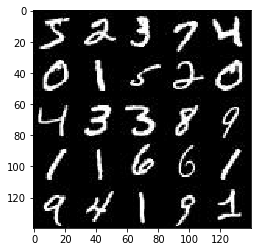

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

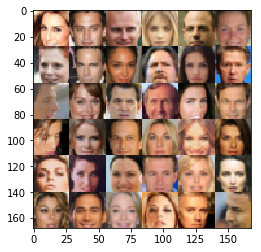

In [5]:
show_n_images = 40

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_ = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "inputs")
    z = tf.placeholder(tf.float32, [None, z_dim], name="z")
    lr = tf.placeholder(tf.float32, name="learning_rate")
    
    return inputs_, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
import numpy as np
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        # input images 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        relu1 = tf.maximum(alpha*x1, x1)
        # 14*14*64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # 7*7*128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # 4*4*256
        
        x4 = tf.layers.conv2d(x3, 512, 3, strides=2, padding="same")
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha*bn4, bn4)
        # 2*2*512
        
        # flatten it
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse= not is_train):
        # Input z
        x1 = tf.layers.dense(z, 4*4*512)
        # 4*4*512
        
        x1 = tf.reshape(x1, (-1,4,4,512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(bn1, alpha*bn1)
        # 4*4*512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(bn2, alpha*bn2)
        # 8*8*256
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(bn3, alpha*bn3)
        # 16*16*128
        
        x4 = tf.layers.conv2d_transpose(relu3, 32, 5, strides=2, padding="same")
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(bn4, alpha*bn4)
        # 32*32*32
        
        x5 = tf.layers.conv2d(relu4, out_channel_dim, 5, strides=1, padding="same")
        logits = tf.image.resize_images(x5, [28,28])
        out = tf.tanh(logits)
        # 28*28*3
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # generator and discriminator
    g_out = generator(input_z, out_channel_dim, is_train=True)
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    # discriminator loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                    labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                    labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    # generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [i for i in t_vars if "generator" in i.name]
    d_vars = [i for i in t_vars if "discriminator" in i.name]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
losses = []
samples = []
tf_cfg = tf.ConfigProto(allow_soft_placement=True)
tf_cfg.gpu_options.per_process_gpu_memory_fraction = 0.4
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # inputs
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    # loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    # opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # generator
    z_generated = generator(input_z, image_channels, is_train=False)
    
    
    iteration = 0
    with tf.Session(config=tf_cfg) as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                iteration += 1
                # sample z
                batch_z = np.random.uniform(-0.5, 0.5, size=(batch_size, z_dim))
                # run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                # show
                if iteration % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                if iteration % 10 == 0:
                # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
#                     # Save losses to view after training
#                     losses.append((train_loss_d, train_loss_g))

#             # Sample from generator as we're training for viewing afterwards
#             sample_z = np.random.uniform(-0.5, 0.5, size=(16, z_dim))
#             gen_samples = sess.run(
#                            z_generated,
#                            feed_dict={input_z: sample_z})
#             samples.append(gen_samples)        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4699... Generator Loss: 15.9023
Epoch 1/2... Discriminator Loss: 1.1933... Generator Loss: 18.1826
Epoch 1/2... Discriminator Loss: 0.7933... Generator Loss: 0.9068
Epoch 1/2... Discriminator Loss: 0.6021... Generator Loss: 1.5327
Epoch 1/2... Discriminator Loss: 0.3115... Generator Loss: 1.6884
Epoch 1/2... Discriminator Loss: 2.2651... Generator Loss: 4.4616
Epoch 1/2... Discriminator Loss: 2.4308... Generator Loss: 0.8214
Epoch 1/2... Discriminator Loss: 0.4259... Generator Loss: 1.3599
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 0.9683


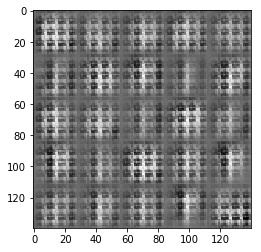

Epoch 1/2... Discriminator Loss: 0.3884... Generator Loss: 2.5119
Epoch 1/2... Discriminator Loss: 0.4606... Generator Loss: 1.6815
Epoch 1/2... Discriminator Loss: 0.8996... Generator Loss: 1.5588
Epoch 1/2... Discriminator Loss: 0.4596... Generator Loss: 1.7671
Epoch 1/2... Discriminator Loss: 0.6916... Generator Loss: 1.4091
Epoch 1/2... Discriminator Loss: 0.9980... Generator Loss: 0.8344
Epoch 1/2... Discriminator Loss: 1.5877... Generator Loss: 0.3602
Epoch 1/2... Discriminator Loss: 0.7585... Generator Loss: 1.0094
Epoch 1/2... Discriminator Loss: 1.0538... Generator Loss: 1.7537
Epoch 1/2... Discriminator Loss: 0.5928... Generator Loss: 1.8366


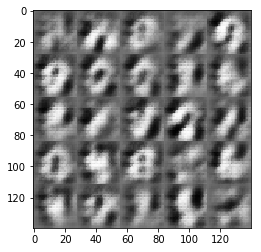

Epoch 1/2... Discriminator Loss: 0.7752... Generator Loss: 0.9389
Epoch 1/2... Discriminator Loss: 1.0643... Generator Loss: 0.6551
Epoch 1/2... Discriminator Loss: 0.7047... Generator Loss: 1.8768
Epoch 1/2... Discriminator Loss: 0.5546... Generator Loss: 1.9247
Epoch 1/2... Discriminator Loss: 1.5885... Generator Loss: 0.3157
Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 0.9954
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 0.6381
Epoch 1/2... Discriminator Loss: 0.7268... Generator Loss: 1.2079
Epoch 1/2... Discriminator Loss: 0.8123... Generator Loss: 1.4845
Epoch 1/2... Discriminator Loss: 0.5188... Generator Loss: 1.7325


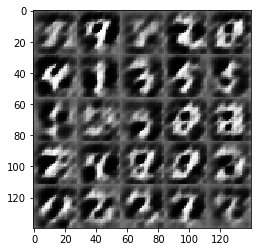

Epoch 1/2... Discriminator Loss: 0.8139... Generator Loss: 2.2663
Epoch 1/2... Discriminator Loss: 0.7218... Generator Loss: 1.5425
Epoch 1/2... Discriminator Loss: 0.7328... Generator Loss: 1.6828
Epoch 1/2... Discriminator Loss: 1.0316... Generator Loss: 1.0233
Epoch 1/2... Discriminator Loss: 0.7949... Generator Loss: 1.3999
Epoch 1/2... Discriminator Loss: 0.7252... Generator Loss: 1.2532
Epoch 1/2... Discriminator Loss: 0.8723... Generator Loss: 1.1824
Epoch 1/2... Discriminator Loss: 0.5819... Generator Loss: 1.9710
Epoch 1/2... Discriminator Loss: 0.9083... Generator Loss: 1.5978
Epoch 1/2... Discriminator Loss: 1.2088... Generator Loss: 0.7311


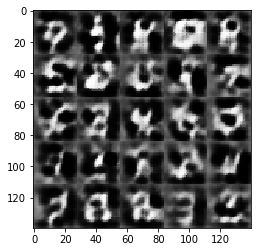

Epoch 1/2... Discriminator Loss: 0.8862... Generator Loss: 1.3262
Epoch 1/2... Discriminator Loss: 0.9355... Generator Loss: 0.8989
Epoch 1/2... Discriminator Loss: 0.8436... Generator Loss: 1.0867
Epoch 1/2... Discriminator Loss: 0.7782... Generator Loss: 2.3363
Epoch 1/2... Discriminator Loss: 0.7998... Generator Loss: 1.4735
Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 0.6738
Epoch 1/2... Discriminator Loss: 0.9613... Generator Loss: 1.3608
Epoch 1/2... Discriminator Loss: 1.0606... Generator Loss: 0.7974
Epoch 1/2... Discriminator Loss: 0.8672... Generator Loss: 0.9864
Epoch 1/2... Discriminator Loss: 0.9279... Generator Loss: 1.4322


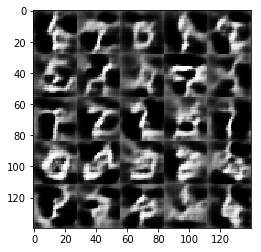

Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 0.8569
Epoch 1/2... Discriminator Loss: 0.9172... Generator Loss: 0.8868
Epoch 1/2... Discriminator Loss: 1.1818... Generator Loss: 0.6333
Epoch 1/2... Discriminator Loss: 1.1672... Generator Loss: 1.1113
Epoch 1/2... Discriminator Loss: 1.1289... Generator Loss: 0.8349
Epoch 1/2... Discriminator Loss: 0.7142... Generator Loss: 1.0791
Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 0.8073
Epoch 1/2... Discriminator Loss: 0.8381... Generator Loss: 1.1843
Epoch 1/2... Discriminator Loss: 1.2463... Generator Loss: 0.6347
Epoch 1/2... Discriminator Loss: 1.2406... Generator Loss: 0.6326


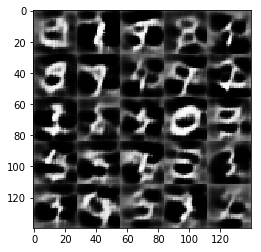

Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 1.3237
Epoch 1/2... Discriminator Loss: 0.9951... Generator Loss: 0.8575
Epoch 1/2... Discriminator Loss: 0.8680... Generator Loss: 1.2024
Epoch 1/2... Discriminator Loss: 0.9019... Generator Loss: 1.5712
Epoch 1/2... Discriminator Loss: 1.2866... Generator Loss: 0.6353
Epoch 1/2... Discriminator Loss: 0.7783... Generator Loss: 1.2447
Epoch 1/2... Discriminator Loss: 0.8468... Generator Loss: 1.1679
Epoch 1/2... Discriminator Loss: 0.9711... Generator Loss: 1.0953
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 0.7868
Epoch 1/2... Discriminator Loss: 0.7433... Generator Loss: 1.3977


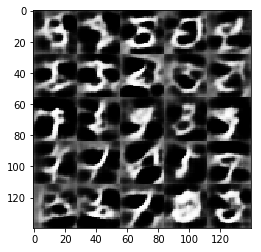

Epoch 1/2... Discriminator Loss: 0.9200... Generator Loss: 1.0039
Epoch 1/2... Discriminator Loss: 1.3283... Generator Loss: 0.5220
Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 1.0623
Epoch 1/2... Discriminator Loss: 1.0315... Generator Loss: 0.9906
Epoch 1/2... Discriminator Loss: 1.1189... Generator Loss: 0.7435
Epoch 1/2... Discriminator Loss: 0.8855... Generator Loss: 1.7062
Epoch 1/2... Discriminator Loss: 1.0812... Generator Loss: 0.6777
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.6437
Epoch 1/2... Discriminator Loss: 0.8516... Generator Loss: 1.1666
Epoch 1/2... Discriminator Loss: 1.1424... Generator Loss: 1.2676


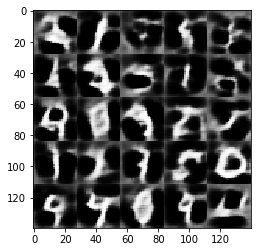

Epoch 1/2... Discriminator Loss: 1.1579... Generator Loss: 0.5676
Epoch 1/2... Discriminator Loss: 0.8429... Generator Loss: 1.2222
Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.5654
Epoch 1/2... Discriminator Loss: 1.4608... Generator Loss: 0.8123
Epoch 1/2... Discriminator Loss: 0.9459... Generator Loss: 0.8802
Epoch 1/2... Discriminator Loss: 1.0282... Generator Loss: 0.8210
Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.5618
Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 0.7619
Epoch 1/2... Discriminator Loss: 1.2234... Generator Loss: 0.6638
Epoch 1/2... Discriminator Loss: 1.4285... Generator Loss: 0.4168


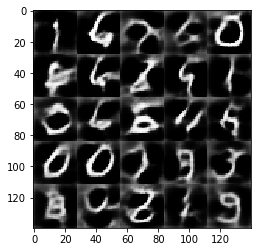

Epoch 1/2... Discriminator Loss: 0.9945... Generator Loss: 0.9027
Epoch 1/2... Discriminator Loss: 0.9951... Generator Loss: 0.9627
Epoch 1/2... Discriminator Loss: 1.4169... Generator Loss: 0.5962
Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 1.0708
Epoch 2/2... Discriminator Loss: 1.2502... Generator Loss: 0.6733
Epoch 2/2... Discriminator Loss: 0.7528... Generator Loss: 1.4434
Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 1.0023... Generator Loss: 1.2188
Epoch 2/2... Discriminator Loss: 1.0627... Generator Loss: 0.8149
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 1.0407


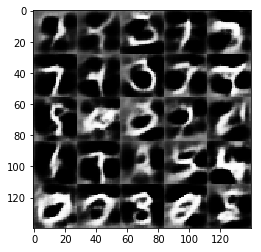

Epoch 2/2... Discriminator Loss: 0.9467... Generator Loss: 1.1036
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 0.7272
Epoch 2/2... Discriminator Loss: 0.7960... Generator Loss: 1.3256
Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 0.8634
Epoch 2/2... Discriminator Loss: 0.9945... Generator Loss: 0.8558
Epoch 2/2... Discriminator Loss: 1.6395... Generator Loss: 0.3583
Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 0.9695
Epoch 2/2... Discriminator Loss: 1.2378... Generator Loss: 0.6658
Epoch 2/2... Discriminator Loss: 1.0956... Generator Loss: 0.8189
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 0.6942


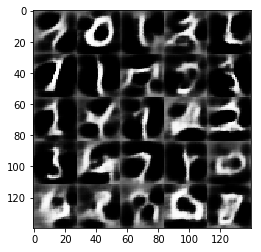

Epoch 2/2... Discriminator Loss: 1.3099... Generator Loss: 0.5337
Epoch 2/2... Discriminator Loss: 1.2445... Generator Loss: 1.2829
Epoch 2/2... Discriminator Loss: 1.0138... Generator Loss: 0.8818
Epoch 2/2... Discriminator Loss: 0.8974... Generator Loss: 1.0810
Epoch 2/2... Discriminator Loss: 1.0900... Generator Loss: 0.8756
Epoch 2/2... Discriminator Loss: 1.0026... Generator Loss: 0.8622
Epoch 2/2... Discriminator Loss: 1.0875... Generator Loss: 1.2212
Epoch 2/2... Discriminator Loss: 1.3478... Generator Loss: 0.4708
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 1.6560
Epoch 2/2... Discriminator Loss: 1.2306... Generator Loss: 0.6690


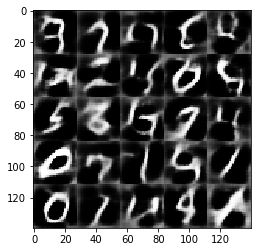

Epoch 2/2... Discriminator Loss: 1.0163... Generator Loss: 0.7569
Epoch 2/2... Discriminator Loss: 0.9295... Generator Loss: 1.4375
Epoch 2/2... Discriminator Loss: 0.9983... Generator Loss: 0.9356
Epoch 2/2... Discriminator Loss: 0.9910... Generator Loss: 0.8746
Epoch 2/2... Discriminator Loss: 1.1266... Generator Loss: 1.0968
Epoch 2/2... Discriminator Loss: 0.8787... Generator Loss: 1.2004
Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 0.6788
Epoch 2/2... Discriminator Loss: 1.1020... Generator Loss: 0.7353
Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 0.5294
Epoch 2/2... Discriminator Loss: 0.8378... Generator Loss: 1.2840


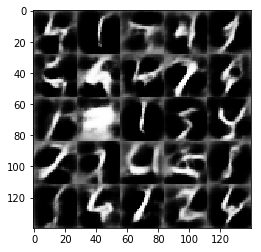

Epoch 2/2... Discriminator Loss: 1.0939... Generator Loss: 0.6456
Epoch 2/2... Discriminator Loss: 1.1313... Generator Loss: 0.8251
Epoch 2/2... Discriminator Loss: 1.2195... Generator Loss: 0.5924
Epoch 2/2... Discriminator Loss: 0.9639... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 1.2943... Generator Loss: 0.4460
Epoch 2/2... Discriminator Loss: 1.1216... Generator Loss: 0.8368
Epoch 2/2... Discriminator Loss: 1.0721... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 1.1381... Generator Loss: 0.7255
Epoch 2/2... Discriminator Loss: 1.1484... Generator Loss: 0.6907
Epoch 2/2... Discriminator Loss: 1.0216... Generator Loss: 1.0395


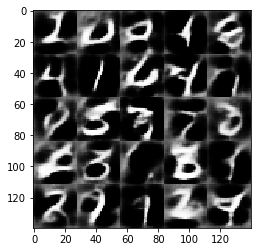

Epoch 2/2... Discriminator Loss: 0.9920... Generator Loss: 1.5965
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 0.8871
Epoch 2/2... Discriminator Loss: 1.4288... Generator Loss: 1.6484
Epoch 2/2... Discriminator Loss: 1.1265... Generator Loss: 0.5906
Epoch 2/2... Discriminator Loss: 1.0969... Generator Loss: 0.6495
Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.5972
Epoch 2/2... Discriminator Loss: 1.0483... Generator Loss: 1.0319
Epoch 2/2... Discriminator Loss: 1.4232... Generator Loss: 0.5433
Epoch 2/2... Discriminator Loss: 1.1433... Generator Loss: 1.0914
Epoch 2/2... Discriminator Loss: 1.1504... Generator Loss: 0.7494


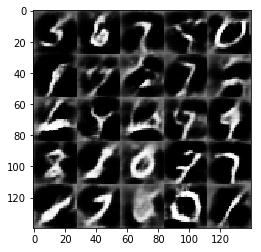

Epoch 2/2... Discriminator Loss: 0.7967... Generator Loss: 1.4863
Epoch 2/2... Discriminator Loss: 0.7994... Generator Loss: 0.9759
Epoch 2/2... Discriminator Loss: 1.0787... Generator Loss: 0.8549
Epoch 2/2... Discriminator Loss: 1.1130... Generator Loss: 0.7333
Epoch 2/2... Discriminator Loss: 1.0071... Generator Loss: 0.7977
Epoch 2/2... Discriminator Loss: 0.9077... Generator Loss: 0.9053
Epoch 2/2... Discriminator Loss: 1.4376... Generator Loss: 0.4010
Epoch 2/2... Discriminator Loss: 1.5124... Generator Loss: 0.3945
Epoch 2/2... Discriminator Loss: 1.2459... Generator Loss: 0.5677
Epoch 2/2... Discriminator Loss: 1.0945... Generator Loss: 0.6492


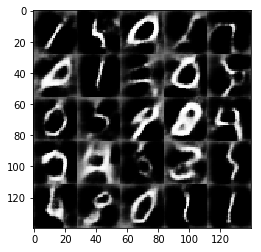

Epoch 2/2... Discriminator Loss: 0.9223... Generator Loss: 1.1119
Epoch 2/2... Discriminator Loss: 1.0478... Generator Loss: 0.9456
Epoch 2/2... Discriminator Loss: 1.1028... Generator Loss: 0.6531
Epoch 2/2... Discriminator Loss: 1.5774... Generator Loss: 0.4028
Epoch 2/2... Discriminator Loss: 1.0291... Generator Loss: 0.7529
Epoch 2/2... Discriminator Loss: 1.4145... Generator Loss: 0.5406
Epoch 2/2... Discriminator Loss: 1.2273... Generator Loss: 0.6971
Epoch 2/2... Discriminator Loss: 1.1714... Generator Loss: 0.6465
Epoch 2/2... Discriminator Loss: 0.9759... Generator Loss: 0.8646
Epoch 2/2... Discriminator Loss: 1.0683... Generator Loss: 0.8326


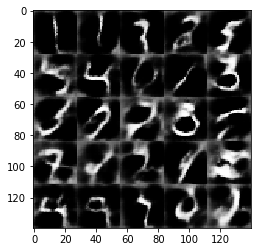

Epoch 2/2... Discriminator Loss: 1.2456... Generator Loss: 0.9270
Epoch 2/2... Discriminator Loss: 1.1408... Generator Loss: 0.8924
Epoch 2/2... Discriminator Loss: 1.3388... Generator Loss: 0.4888
Epoch 2/2... Discriminator Loss: 1.0446... Generator Loss: 0.6634
Epoch 2/2... Discriminator Loss: 1.2579... Generator Loss: 0.4710
Epoch 2/2... Discriminator Loss: 0.9253... Generator Loss: 0.8494
Epoch 2/2... Discriminator Loss: 1.1384... Generator Loss: 0.5880
Epoch 2/2... Discriminator Loss: 1.7685... Generator Loss: 3.0205
Epoch 2/2... Discriminator Loss: 1.1834... Generator Loss: 0.5287
Epoch 2/2... Discriminator Loss: 1.0363... Generator Loss: 0.6707


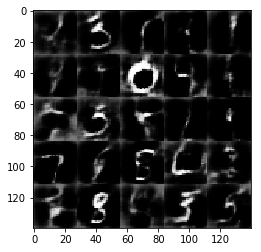

Epoch 2/2... Discriminator Loss: 1.7610... Generator Loss: 0.2497
Epoch 2/2... Discriminator Loss: 1.0338... Generator Loss: 0.8452
Epoch 2/2... Discriminator Loss: 1.5808... Generator Loss: 0.3339
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.6880
Epoch 2/2... Discriminator Loss: 1.0815... Generator Loss: 1.2378
Epoch 2/2... Discriminator Loss: 1.3054... Generator Loss: 0.5423
Epoch 2/2... Discriminator Loss: 0.8797... Generator Loss: 0.7847
Epoch 2/2... Discriminator Loss: 0.9672... Generator Loss: 0.8694


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.0625... Generator Loss: 3.9408
Epoch 1/2... Discriminator Loss: 0.6556... Generator Loss: 11.8292
Epoch 1/2... Discriminator Loss: 3.3223... Generator Loss: 0.0490
Epoch 1/2... Discriminator Loss: 1.1938... Generator Loss: 2.0585
Epoch 1/2... Discriminator Loss: 1.7777... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 1.4686... Generator Loss: 0.6342
Epoch 1/2... Discriminator Loss: 1.1429... Generator Loss: 0.5515
Epoch 1/2... Discriminator Loss: 1.5573... Generator Loss: 0.6060
Epoch 1/2... Discriminator Loss: 1.1405... Generator Loss: 0.5827


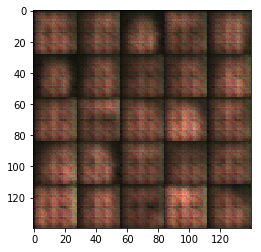

Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 0.9176
Epoch 1/2... Discriminator Loss: 2.1905... Generator Loss: 0.2422
Epoch 1/2... Discriminator Loss: 1.3569... Generator Loss: 0.6483
Epoch 1/2... Discriminator Loss: 0.9152... Generator Loss: 1.1506
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 0.8554
Epoch 1/2... Discriminator Loss: 1.6285... Generator Loss: 0.5632
Epoch 1/2... Discriminator Loss: 3.1047... Generator Loss: 4.9802
Epoch 1/2... Discriminator Loss: 1.2115... Generator Loss: 0.7657
Epoch 1/2... Discriminator Loss: 1.2900... Generator Loss: 0.8303
Epoch 1/2... Discriminator Loss: 1.4196... Generator Loss: 0.6001


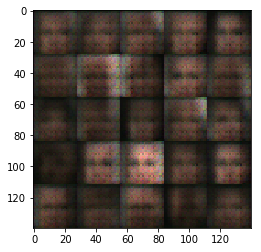

Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.7242
Epoch 1/2... Discriminator Loss: 1.2119... Generator Loss: 0.7071
Epoch 1/2... Discriminator Loss: 1.3493... Generator Loss: 0.6828
Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 0.7447
Epoch 1/2... Discriminator Loss: 1.4611... Generator Loss: 0.5690
Epoch 1/2... Discriminator Loss: 1.4880... Generator Loss: 0.6327
Epoch 1/2... Discriminator Loss: 1.1535... Generator Loss: 0.9014
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 0.5877
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 1.1258
Epoch 1/2... Discriminator Loss: 1.1775... Generator Loss: 0.8562


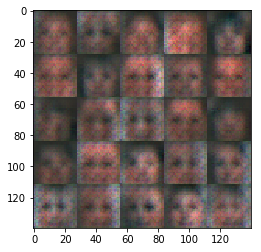

Epoch 1/2... Discriminator Loss: 1.3209... Generator Loss: 0.7782
Epoch 1/2... Discriminator Loss: 1.0903... Generator Loss: 1.0686
Epoch 1/2... Discriminator Loss: 0.9943... Generator Loss: 0.8081
Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 0.6405
Epoch 1/2... Discriminator Loss: 1.1601... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 1.4688... Generator Loss: 0.9382
Epoch 1/2... Discriminator Loss: 0.7847... Generator Loss: 1.1835
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 1.4190
Epoch 1/2... Discriminator Loss: 1.2632... Generator Loss: 0.7110
Epoch 1/2... Discriminator Loss: 1.7081... Generator Loss: 1.0912


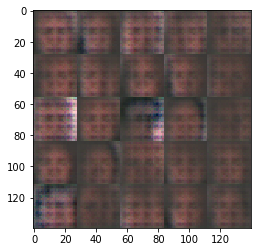

Epoch 1/2... Discriminator Loss: 1.0640... Generator Loss: 0.9156
Epoch 1/2... Discriminator Loss: 1.2839... Generator Loss: 0.8998
Epoch 1/2... Discriminator Loss: 1.3378... Generator Loss: 1.0037
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 1.0120
Epoch 1/2... Discriminator Loss: 1.0194... Generator Loss: 0.9862
Epoch 1/2... Discriminator Loss: 1.1601... Generator Loss: 0.7386
Epoch 1/2... Discriminator Loss: 1.3476... Generator Loss: 0.8044
Epoch 1/2... Discriminator Loss: 1.4892... Generator Loss: 0.7295
Epoch 1/2... Discriminator Loss: 1.2335... Generator Loss: 0.7484
Epoch 1/2... Discriminator Loss: 1.0115... Generator Loss: 1.0035


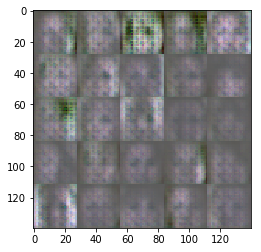

Epoch 1/2... Discriminator Loss: 1.1540... Generator Loss: 0.9094
Epoch 1/2... Discriminator Loss: 1.5187... Generator Loss: 0.5614
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 0.6710
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 0.7608
Epoch 1/2... Discriminator Loss: 1.2411... Generator Loss: 0.8495
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.7003
Epoch 1/2... Discriminator Loss: 1.2365... Generator Loss: 1.0911
Epoch 1/2... Discriminator Loss: 1.0652... Generator Loss: 0.6970
Epoch 1/2... Discriminator Loss: 1.7361... Generator Loss: 0.3986
Epoch 1/2... Discriminator Loss: 1.2724... Generator Loss: 0.6461


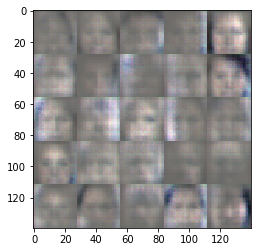

Epoch 1/2... Discriminator Loss: 1.2631... Generator Loss: 0.5512
Epoch 1/2... Discriminator Loss: 1.3028... Generator Loss: 0.9134
Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 0.6676
Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 0.8668
Epoch 1/2... Discriminator Loss: 1.0420... Generator Loss: 1.1829
Epoch 1/2... Discriminator Loss: 1.0189... Generator Loss: 0.8296
Epoch 1/2... Discriminator Loss: 1.0030... Generator Loss: 1.4122
Epoch 1/2... Discriminator Loss: 1.2803... Generator Loss: 1.2769
Epoch 1/2... Discriminator Loss: 1.1751... Generator Loss: 1.2878
Epoch 1/2... Discriminator Loss: 0.9382... Generator Loss: 1.0602


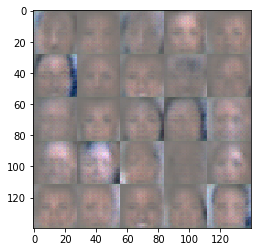

Epoch 1/2... Discriminator Loss: 1.1074... Generator Loss: 0.8404
Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.5755
Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 1.3894
Epoch 1/2... Discriminator Loss: 1.0099... Generator Loss: 1.2985
Epoch 1/2... Discriminator Loss: 1.7301... Generator Loss: 2.5542
Epoch 1/2... Discriminator Loss: 0.8253... Generator Loss: 1.1331
Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 0.5866
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 1.0780
Epoch 1/2... Discriminator Loss: 1.0583... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 0.6389


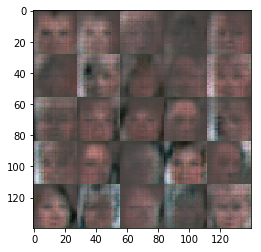

Epoch 1/2... Discriminator Loss: 1.3148... Generator Loss: 0.5443
Epoch 1/2... Discriminator Loss: 1.2476... Generator Loss: 0.6708
Epoch 1/2... Discriminator Loss: 1.5885... Generator Loss: 0.4487
Epoch 1/2... Discriminator Loss: 1.0389... Generator Loss: 0.7075
Epoch 1/2... Discriminator Loss: 1.1364... Generator Loss: 0.7072
Epoch 1/2... Discriminator Loss: 1.2040... Generator Loss: 1.2306
Epoch 1/2... Discriminator Loss: 1.4552... Generator Loss: 0.6277
Epoch 1/2... Discriminator Loss: 1.0118... Generator Loss: 0.7364
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 0.7459
Epoch 1/2... Discriminator Loss: 1.1776... Generator Loss: 0.7796


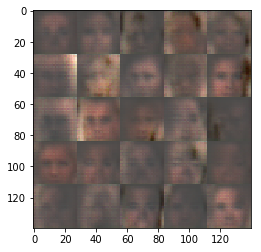

Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 0.7725
Epoch 1/2... Discriminator Loss: 1.0788... Generator Loss: 0.7233
Epoch 1/2... Discriminator Loss: 1.5649... Generator Loss: 0.5256
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 0.6424
Epoch 1/2... Discriminator Loss: 1.1833... Generator Loss: 1.0629
Epoch 1/2... Discriminator Loss: 1.2132... Generator Loss: 0.7304
Epoch 1/2... Discriminator Loss: 0.9608... Generator Loss: 1.0524
Epoch 1/2... Discriminator Loss: 0.9819... Generator Loss: 1.0658
Epoch 1/2... Discriminator Loss: 1.2461... Generator Loss: 0.6539
Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 1.0487


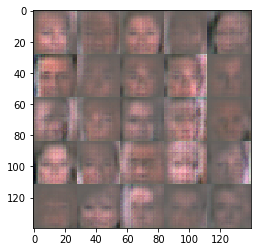

Epoch 1/2... Discriminator Loss: 1.3096... Generator Loss: 0.8204
Epoch 1/2... Discriminator Loss: 1.1452... Generator Loss: 1.1063
Epoch 1/2... Discriminator Loss: 1.1458... Generator Loss: 0.9802
Epoch 1/2... Discriminator Loss: 1.2917... Generator Loss: 0.9141
Epoch 1/2... Discriminator Loss: 1.2633... Generator Loss: 1.4426
Epoch 1/2... Discriminator Loss: 1.2876... Generator Loss: 1.0948
Epoch 1/2... Discriminator Loss: 1.1600... Generator Loss: 0.9685
Epoch 1/2... Discriminator Loss: 1.2800... Generator Loss: 1.3290
Epoch 1/2... Discriminator Loss: 2.0375... Generator Loss: 0.1944
Epoch 1/2... Discriminator Loss: 1.1220... Generator Loss: 0.8955


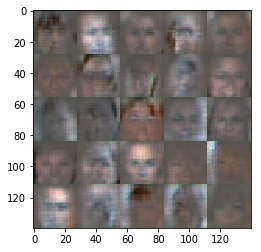

Epoch 1/2... Discriminator Loss: 1.1248... Generator Loss: 0.7624
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 0.6809
Epoch 1/2... Discriminator Loss: 1.0037... Generator Loss: 1.2305
Epoch 1/2... Discriminator Loss: 1.0905... Generator Loss: 0.8524
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.8384
Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 0.6845
Epoch 1/2... Discriminator Loss: 1.2115... Generator Loss: 0.6918
Epoch 1/2... Discriminator Loss: 1.2018... Generator Loss: 0.8241
Epoch 1/2... Discriminator Loss: 1.1406... Generator Loss: 0.7377
Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 0.5189


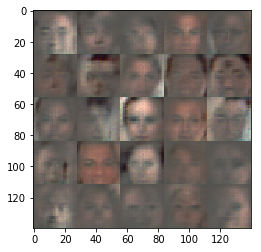

Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 0.9804
Epoch 1/2... Discriminator Loss: 1.0200... Generator Loss: 0.8479
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 1.1860
Epoch 1/2... Discriminator Loss: 1.0028... Generator Loss: 0.7612
Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 0.7829
Epoch 1/2... Discriminator Loss: 1.2184... Generator Loss: 1.1206
Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 1.0713
Epoch 1/2... Discriminator Loss: 1.1866... Generator Loss: 1.4299
Epoch 1/2... Discriminator Loss: 1.4184... Generator Loss: 0.8630
Epoch 1/2... Discriminator Loss: 1.1980... Generator Loss: 1.6773


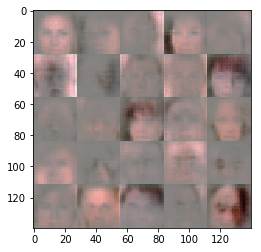

Epoch 1/2... Discriminator Loss: 0.8580... Generator Loss: 1.5483
Epoch 1/2... Discriminator Loss: 1.1568... Generator Loss: 0.7637
Epoch 1/2... Discriminator Loss: 1.1885... Generator Loss: 0.5596
Epoch 1/2... Discriminator Loss: 0.9516... Generator Loss: 1.3006
Epoch 1/2... Discriminator Loss: 1.2164... Generator Loss: 0.6700
Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 0.4343
Epoch 1/2... Discriminator Loss: 1.1226... Generator Loss: 0.7633
Epoch 1/2... Discriminator Loss: 1.1375... Generator Loss: 0.6450
Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 0.8950
Epoch 1/2... Discriminator Loss: 0.7820... Generator Loss: 1.1972


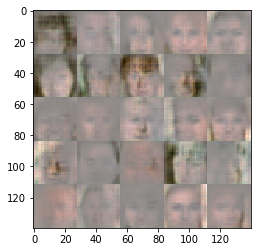

Epoch 1/2... Discriminator Loss: 1.0373... Generator Loss: 1.0436
Epoch 1/2... Discriminator Loss: 1.3410... Generator Loss: 0.4772
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.6045
Epoch 1/2... Discriminator Loss: 1.1421... Generator Loss: 1.0944
Epoch 1/2... Discriminator Loss: 0.9730... Generator Loss: 0.9619
Epoch 1/2... Discriminator Loss: 0.9124... Generator Loss: 0.9449
Epoch 1/2... Discriminator Loss: 1.2688... Generator Loss: 0.4947
Epoch 1/2... Discriminator Loss: 1.1452... Generator Loss: 0.9552
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.4642
Epoch 1/2... Discriminator Loss: 1.2707... Generator Loss: 0.7496


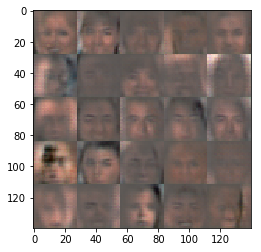

Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 0.6415
Epoch 1/2... Discriminator Loss: 0.9312... Generator Loss: 1.1098
Epoch 1/2... Discriminator Loss: 1.0034... Generator Loss: 0.8120
Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 0.9232
Epoch 1/2... Discriminator Loss: 0.9876... Generator Loss: 0.9888
Epoch 1/2... Discriminator Loss: 1.4535... Generator Loss: 0.6099
Epoch 1/2... Discriminator Loss: 1.0989... Generator Loss: 0.9386
Epoch 1/2... Discriminator Loss: 1.0010... Generator Loss: 0.9190
Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 0.8533
Epoch 1/2... Discriminator Loss: 1.6743... Generator Loss: 0.8002


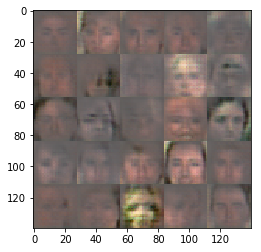

Epoch 1/2... Discriminator Loss: 1.1849... Generator Loss: 0.7795
Epoch 1/2... Discriminator Loss: 0.9595... Generator Loss: 0.9517
Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 0.9684
Epoch 1/2... Discriminator Loss: 1.2356... Generator Loss: 0.6815
Epoch 1/2... Discriminator Loss: 0.9674... Generator Loss: 1.1693
Epoch 1/2... Discriminator Loss: 0.8431... Generator Loss: 0.9927
Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 1.0016
Epoch 1/2... Discriminator Loss: 1.1083... Generator Loss: 0.8371
Epoch 1/2... Discriminator Loss: 1.0689... Generator Loss: 0.7236
Epoch 1/2... Discriminator Loss: 1.1489... Generator Loss: 0.8200


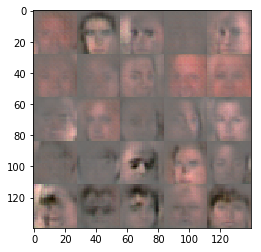

Epoch 1/2... Discriminator Loss: 0.9376... Generator Loss: 1.0698
Epoch 1/2... Discriminator Loss: 1.1886... Generator Loss: 0.6309
Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 0.8265
Epoch 1/2... Discriminator Loss: 1.0980... Generator Loss: 0.9665
Epoch 1/2... Discriminator Loss: 1.7881... Generator Loss: 0.4658
Epoch 1/2... Discriminator Loss: 1.1969... Generator Loss: 0.8356
Epoch 1/2... Discriminator Loss: 1.2529... Generator Loss: 0.7800
Epoch 1/2... Discriminator Loss: 0.8528... Generator Loss: 0.9561
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 0.5518
Epoch 1/2... Discriminator Loss: 0.8955... Generator Loss: 1.0296


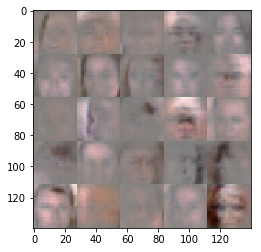

Epoch 1/2... Discriminator Loss: 1.4509... Generator Loss: 0.5299
Epoch 1/2... Discriminator Loss: 1.2546... Generator Loss: 0.5867
Epoch 1/2... Discriminator Loss: 1.8140... Generator Loss: 1.1427
Epoch 1/2... Discriminator Loss: 1.1716... Generator Loss: 0.8131
Epoch 1/2... Discriminator Loss: 1.0644... Generator Loss: 0.8408
Epoch 1/2... Discriminator Loss: 1.0806... Generator Loss: 0.8691
Epoch 1/2... Discriminator Loss: 1.1479... Generator Loss: 0.6648
Epoch 1/2... Discriminator Loss: 1.0737... Generator Loss: 0.7932
Epoch 1/2... Discriminator Loss: 1.2383... Generator Loss: 0.4890
Epoch 1/2... Discriminator Loss: 1.0404... Generator Loss: 1.0832


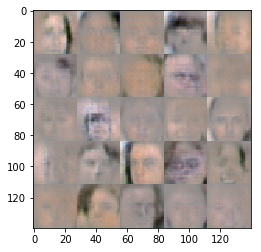

Epoch 1/2... Discriminator Loss: 1.1176... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 0.7088
Epoch 1/2... Discriminator Loss: 1.3132... Generator Loss: 0.5407
Epoch 1/2... Discriminator Loss: 1.1111... Generator Loss: 1.0342
Epoch 1/2... Discriminator Loss: 1.1139... Generator Loss: 1.2568
Epoch 1/2... Discriminator Loss: 1.2032... Generator Loss: 1.2570
Epoch 1/2... Discriminator Loss: 1.0300... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 0.6612
Epoch 1/2... Discriminator Loss: 1.0375... Generator Loss: 0.8314
Epoch 1/2... Discriminator Loss: 1.0712... Generator Loss: 0.7551


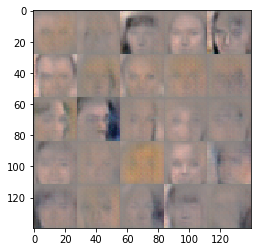

Epoch 1/2... Discriminator Loss: 1.1342... Generator Loss: 0.8300
Epoch 1/2... Discriminator Loss: 1.0719... Generator Loss: 0.7838
Epoch 1/2... Discriminator Loss: 1.0251... Generator Loss: 0.7761
Epoch 1/2... Discriminator Loss: 0.9518... Generator Loss: 1.0763
Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 0.8621
Epoch 1/2... Discriminator Loss: 1.2081... Generator Loss: 0.9819
Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 1.0175
Epoch 1/2... Discriminator Loss: 1.2175... Generator Loss: 0.6514
Epoch 1/2... Discriminator Loss: 1.1379... Generator Loss: 0.6998
Epoch 1/2... Discriminator Loss: 1.1625... Generator Loss: 0.7327


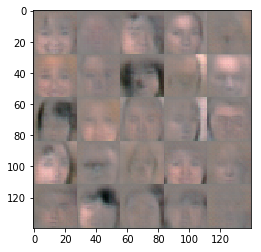

Epoch 1/2... Discriminator Loss: 1.0544... Generator Loss: 0.6526
Epoch 1/2... Discriminator Loss: 1.0426... Generator Loss: 0.8066
Epoch 1/2... Discriminator Loss: 1.2067... Generator Loss: 0.7429
Epoch 1/2... Discriminator Loss: 1.0583... Generator Loss: 0.7599
Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 0.6527
Epoch 1/2... Discriminator Loss: 1.0033... Generator Loss: 0.9901
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 0.6994
Epoch 1/2... Discriminator Loss: 0.8831... Generator Loss: 0.9800
Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 1.0025
Epoch 1/2... Discriminator Loss: 1.1648... Generator Loss: 1.0063


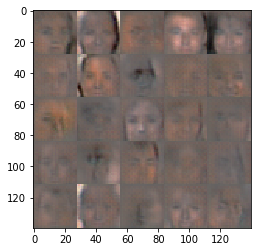

Epoch 1/2... Discriminator Loss: 1.1338... Generator Loss: 0.9331
Epoch 1/2... Discriminator Loss: 1.0809... Generator Loss: 1.1553
Epoch 1/2... Discriminator Loss: 1.2222... Generator Loss: 0.6276
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 0.7681
Epoch 1/2... Discriminator Loss: 1.1765... Generator Loss: 1.1301
Epoch 1/2... Discriminator Loss: 1.1072... Generator Loss: 0.7308
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 1.0119
Epoch 1/2... Discriminator Loss: 1.2155... Generator Loss: 0.7157
Epoch 1/2... Discriminator Loss: 1.4089... Generator Loss: 0.4910
Epoch 1/2... Discriminator Loss: 0.9076... Generator Loss: 0.9612


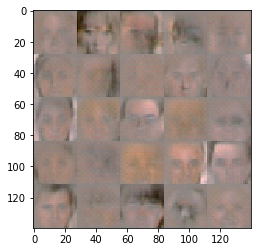

Epoch 1/2... Discriminator Loss: 0.9574... Generator Loss: 1.1340
Epoch 1/2... Discriminator Loss: 1.0835... Generator Loss: 0.8911
Epoch 1/2... Discriminator Loss: 1.2182... Generator Loss: 0.6398
Epoch 1/2... Discriminator Loss: 1.1338... Generator Loss: 0.7390
Epoch 1/2... Discriminator Loss: 1.1078... Generator Loss: 0.7516
Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 1.4500
Epoch 1/2... Discriminator Loss: 1.2882... Generator Loss: 1.3757
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 0.9070
Epoch 1/2... Discriminator Loss: 1.1946... Generator Loss: 0.5496
Epoch 1/2... Discriminator Loss: 1.1166... Generator Loss: 0.5921


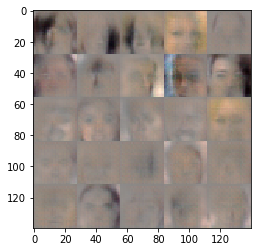

Epoch 1/2... Discriminator Loss: 1.0655... Generator Loss: 0.7251
Epoch 1/2... Discriminator Loss: 1.0053... Generator Loss: 1.1444
Epoch 1/2... Discriminator Loss: 1.0553... Generator Loss: 0.8373
Epoch 1/2... Discriminator Loss: 1.1928... Generator Loss: 0.9328
Epoch 1/2... Discriminator Loss: 1.0765... Generator Loss: 0.9327
Epoch 1/2... Discriminator Loss: 0.9748... Generator Loss: 1.2996
Epoch 1/2... Discriminator Loss: 1.1155... Generator Loss: 0.6734
Epoch 1/2... Discriminator Loss: 0.9428... Generator Loss: 0.9538
Epoch 1/2... Discriminator Loss: 0.9270... Generator Loss: 1.0963
Epoch 1/2... Discriminator Loss: 1.3396... Generator Loss: 0.7506


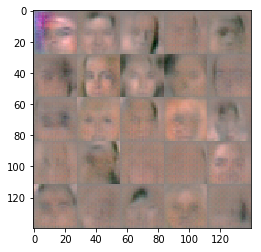

Epoch 1/2... Discriminator Loss: 1.1568... Generator Loss: 0.9189
Epoch 1/2... Discriminator Loss: 1.1356... Generator Loss: 0.9458
Epoch 1/2... Discriminator Loss: 0.9852... Generator Loss: 0.9129
Epoch 1/2... Discriminator Loss: 0.9847... Generator Loss: 0.8746
Epoch 1/2... Discriminator Loss: 0.9293... Generator Loss: 1.0636
Epoch 1/2... Discriminator Loss: 1.3172... Generator Loss: 0.9184
Epoch 1/2... Discriminator Loss: 1.1371... Generator Loss: 1.0908
Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 1.3459
Epoch 1/2... Discriminator Loss: 1.0725... Generator Loss: 0.8438
Epoch 1/2... Discriminator Loss: 1.1233... Generator Loss: 0.8947


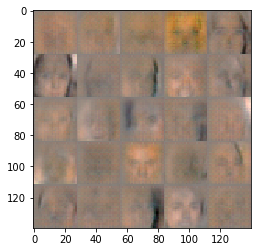

Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 0.6687
Epoch 1/2... Discriminator Loss: 1.2923... Generator Loss: 0.5319
Epoch 1/2... Discriminator Loss: 1.1080... Generator Loss: 0.8892
Epoch 1/2... Discriminator Loss: 1.5665... Generator Loss: 0.3940
Epoch 1/2... Discriminator Loss: 1.1004... Generator Loss: 1.1306
Epoch 1/2... Discriminator Loss: 1.1479... Generator Loss: 0.6628
Epoch 1/2... Discriminator Loss: 1.2783... Generator Loss: 0.6880
Epoch 1/2... Discriminator Loss: 1.0520... Generator Loss: 0.7727
Epoch 1/2... Discriminator Loss: 0.9126... Generator Loss: 1.0631
Epoch 1/2... Discriminator Loss: 1.2876... Generator Loss: 0.6691


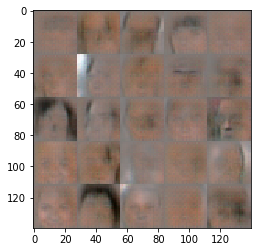

Epoch 1/2... Discriminator Loss: 0.9649... Generator Loss: 0.9553
Epoch 1/2... Discriminator Loss: 1.1151... Generator Loss: 0.6461
Epoch 1/2... Discriminator Loss: 1.0765... Generator Loss: 0.6629
Epoch 1/2... Discriminator Loss: 1.1872... Generator Loss: 0.5927
Epoch 1/2... Discriminator Loss: 0.9865... Generator Loss: 0.8329
Epoch 1/2... Discriminator Loss: 0.9559... Generator Loss: 1.1594
Epoch 1/2... Discriminator Loss: 1.0054... Generator Loss: 0.9280
Epoch 1/2... Discriminator Loss: 1.0579... Generator Loss: 0.7727
Epoch 1/2... Discriminator Loss: 1.0491... Generator Loss: 0.8322
Epoch 1/2... Discriminator Loss: 1.1363... Generator Loss: 1.1956


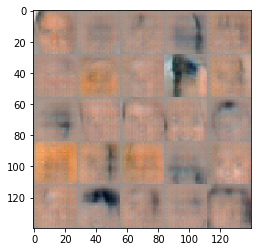

Epoch 1/2... Discriminator Loss: 1.1029... Generator Loss: 1.1312
Epoch 1/2... Discriminator Loss: 1.2775... Generator Loss: 0.6655
Epoch 1/2... Discriminator Loss: 0.9752... Generator Loss: 0.9573
Epoch 1/2... Discriminator Loss: 1.0404... Generator Loss: 0.7767
Epoch 1/2... Discriminator Loss: 1.3090... Generator Loss: 0.6343
Epoch 1/2... Discriminator Loss: 0.9734... Generator Loss: 1.2385
Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 0.9617
Epoch 1/2... Discriminator Loss: 0.9611... Generator Loss: 0.9607
Epoch 1/2... Discriminator Loss: 0.9726... Generator Loss: 1.0617
Epoch 1/2... Discriminator Loss: 0.9910... Generator Loss: 1.1598


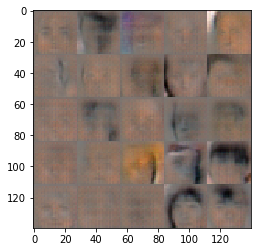

Epoch 1/2... Discriminator Loss: 1.1581... Generator Loss: 0.7360
Epoch 1/2... Discriminator Loss: 0.9066... Generator Loss: 1.0229
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 0.6621
Epoch 1/2... Discriminator Loss: 1.1055... Generator Loss: 0.7398
Epoch 1/2... Discriminator Loss: 0.9451... Generator Loss: 0.8536
Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 0.9468
Epoch 1/2... Discriminator Loss: 1.0088... Generator Loss: 1.3391
Epoch 1/2... Discriminator Loss: 0.9435... Generator Loss: 1.0520
Epoch 1/2... Discriminator Loss: 1.1136... Generator Loss: 0.8974
Epoch 1/2... Discriminator Loss: 1.1376... Generator Loss: 0.7958


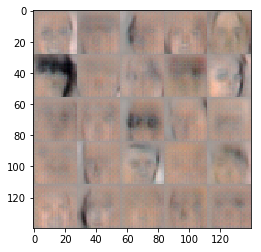

Epoch 1/2... Discriminator Loss: 1.3787... Generator Loss: 0.4361
Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 1.1132
Epoch 1/2... Discriminator Loss: 1.1239... Generator Loss: 0.6084
Epoch 1/2... Discriminator Loss: 1.0112... Generator Loss: 1.2007
Epoch 1/2... Discriminator Loss: 1.0811... Generator Loss: 0.8722
Epoch 1/2... Discriminator Loss: 1.1226... Generator Loss: 0.6439
Epoch 1/2... Discriminator Loss: 1.1635... Generator Loss: 0.7436
Epoch 1/2... Discriminator Loss: 1.0299... Generator Loss: 0.8020
Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 0.7314
Epoch 1/2... Discriminator Loss: 1.1627... Generator Loss: 0.6908


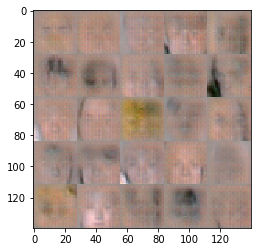

Epoch 1/2... Discriminator Loss: 1.1958... Generator Loss: 0.6602
Epoch 1/2... Discriminator Loss: 0.9567... Generator Loss: 0.9905
Epoch 1/2... Discriminator Loss: 1.1013... Generator Loss: 0.9346
Epoch 1/2... Discriminator Loss: 1.1907... Generator Loss: 0.7048
Epoch 1/2... Discriminator Loss: 1.9117... Generator Loss: 2.5876
Epoch 1/2... Discriminator Loss: 1.1930... Generator Loss: 0.6142
Epoch 1/2... Discriminator Loss: 1.1586... Generator Loss: 0.8710
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.5390
Epoch 2/2... Discriminator Loss: 1.0669... Generator Loss: 1.1677
Epoch 2/2... Discriminator Loss: 1.3429... Generator Loss: 0.4918


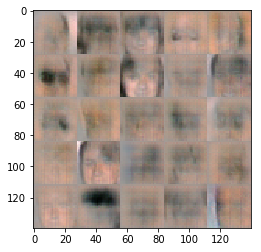

Epoch 2/2... Discriminator Loss: 0.9599... Generator Loss: 1.0011
Epoch 2/2... Discriminator Loss: 1.0246... Generator Loss: 0.8715
Epoch 2/2... Discriminator Loss: 0.9741... Generator Loss: 0.9308
Epoch 2/2... Discriminator Loss: 0.9649... Generator Loss: 1.0503
Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 0.8135
Epoch 2/2... Discriminator Loss: 1.2024... Generator Loss: 1.1907
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 0.9855
Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 1.1694
Epoch 2/2... Discriminator Loss: 0.9673... Generator Loss: 0.9167
Epoch 2/2... Discriminator Loss: 1.0393... Generator Loss: 1.1443


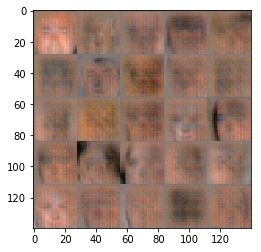

Epoch 2/2... Discriminator Loss: 1.0503... Generator Loss: 0.8097
Epoch 2/2... Discriminator Loss: 1.1969... Generator Loss: 0.7233
Epoch 2/2... Discriminator Loss: 0.9451... Generator Loss: 0.8189
Epoch 2/2... Discriminator Loss: 1.1270... Generator Loss: 0.9498
Epoch 2/2... Discriminator Loss: 1.0331... Generator Loss: 0.9785
Epoch 2/2... Discriminator Loss: 0.9890... Generator Loss: 1.0605
Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 1.0371
Epoch 2/2... Discriminator Loss: 1.0268... Generator Loss: 1.3675
Epoch 2/2... Discriminator Loss: 1.2055... Generator Loss: 0.6149
Epoch 2/2... Discriminator Loss: 1.0426... Generator Loss: 0.7367


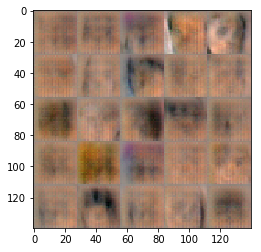

Epoch 2/2... Discriminator Loss: 1.0350... Generator Loss: 0.7703
Epoch 2/2... Discriminator Loss: 1.1394... Generator Loss: 0.7480
Epoch 2/2... Discriminator Loss: 0.9219... Generator Loss: 0.8871
Epoch 2/2... Discriminator Loss: 1.1526... Generator Loss: 0.9637
Epoch 2/2... Discriminator Loss: 1.1828... Generator Loss: 0.6601
Epoch 2/2... Discriminator Loss: 0.9856... Generator Loss: 0.8142
Epoch 2/2... Discriminator Loss: 1.1416... Generator Loss: 0.6607
Epoch 2/2... Discriminator Loss: 1.0930... Generator Loss: 1.3468
Epoch 2/2... Discriminator Loss: 1.2004... Generator Loss: 0.6536
Epoch 2/2... Discriminator Loss: 1.1827... Generator Loss: 0.6199


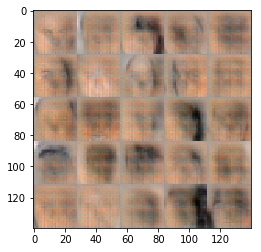

Epoch 2/2... Discriminator Loss: 0.9968... Generator Loss: 1.0753
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 1.0000
Epoch 2/2... Discriminator Loss: 1.2292... Generator Loss: 0.5372
Epoch 2/2... Discriminator Loss: 1.1132... Generator Loss: 0.8241
Epoch 2/2... Discriminator Loss: 1.0588... Generator Loss: 0.8981
Epoch 2/2... Discriminator Loss: 1.0596... Generator Loss: 1.3393
Epoch 2/2... Discriminator Loss: 1.0809... Generator Loss: 0.6474
Epoch 2/2... Discriminator Loss: 1.2413... Generator Loss: 0.5520
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.6185
Epoch 2/2... Discriminator Loss: 1.2450... Generator Loss: 0.5007


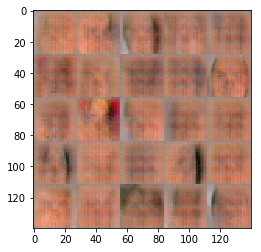

Epoch 2/2... Discriminator Loss: 1.0026... Generator Loss: 0.7290
Epoch 2/2... Discriminator Loss: 1.1030... Generator Loss: 0.7785
Epoch 2/2... Discriminator Loss: 0.8867... Generator Loss: 0.9856
Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 0.6091
Epoch 2/2... Discriminator Loss: 0.8888... Generator Loss: 1.0783
Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 0.9560
Epoch 2/2... Discriminator Loss: 1.1388... Generator Loss: 0.6511
Epoch 2/2... Discriminator Loss: 1.0627... Generator Loss: 1.2950
Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 1.2314
Epoch 2/2... Discriminator Loss: 1.2006... Generator Loss: 0.5903


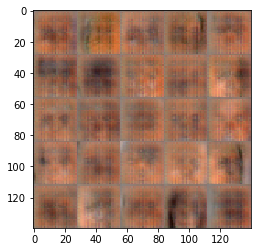

Epoch 2/2... Discriminator Loss: 1.3030... Generator Loss: 1.3834
Epoch 2/2... Discriminator Loss: 1.1788... Generator Loss: 1.0953
Epoch 2/2... Discriminator Loss: 1.1475... Generator Loss: 1.1362
Epoch 2/2... Discriminator Loss: 1.0586... Generator Loss: 0.8506
Epoch 2/2... Discriminator Loss: 1.3148... Generator Loss: 0.5599
Epoch 2/2... Discriminator Loss: 1.0551... Generator Loss: 0.7604
Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 0.9855
Epoch 2/2... Discriminator Loss: 1.1493... Generator Loss: 0.7239
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.6303
Epoch 2/2... Discriminator Loss: 1.1709... Generator Loss: 0.6774


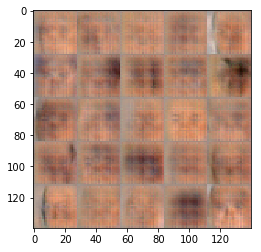

Epoch 2/2... Discriminator Loss: 1.1068... Generator Loss: 0.7036
Epoch 2/2... Discriminator Loss: 1.0686... Generator Loss: 0.9174
Epoch 2/2... Discriminator Loss: 1.1471... Generator Loss: 0.9030
Epoch 2/2... Discriminator Loss: 1.0996... Generator Loss: 0.8212
Epoch 2/2... Discriminator Loss: 0.9603... Generator Loss: 0.9504
Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 0.6094
Epoch 2/2... Discriminator Loss: 1.2678... Generator Loss: 0.7260
Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 1.4544
Epoch 2/2... Discriminator Loss: 0.9885... Generator Loss: 0.9105
Epoch 2/2... Discriminator Loss: 1.1714... Generator Loss: 1.0624


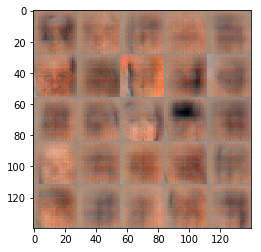

Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 0.7379
Epoch 2/2... Discriminator Loss: 1.2326... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.1603... Generator Loss: 0.7485
Epoch 2/2... Discriminator Loss: 1.2675... Generator Loss: 0.7809
Epoch 2/2... Discriminator Loss: 1.0971... Generator Loss: 1.1453
Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 0.7490
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.7950
Epoch 2/2... Discriminator Loss: 1.5230... Generator Loss: 0.3558
Epoch 2/2... Discriminator Loss: 1.1076... Generator Loss: 1.1682
Epoch 2/2... Discriminator Loss: 1.1188... Generator Loss: 1.3419


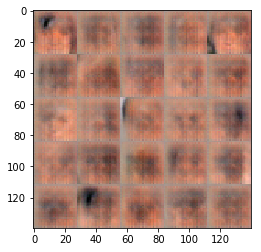

Epoch 2/2... Discriminator Loss: 1.1504... Generator Loss: 1.1295
Epoch 2/2... Discriminator Loss: 1.0731... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 1.1485... Generator Loss: 0.7622
Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 0.7864
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 0.9256
Epoch 2/2... Discriminator Loss: 1.2066... Generator Loss: 0.5838
Epoch 2/2... Discriminator Loss: 1.0631... Generator Loss: 0.7139
Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 0.8646
Epoch 2/2... Discriminator Loss: 1.1772... Generator Loss: 0.6805
Epoch 2/2... Discriminator Loss: 1.0355... Generator Loss: 1.3153


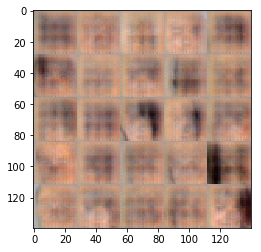

Epoch 2/2... Discriminator Loss: 1.0081... Generator Loss: 1.3573
Epoch 2/2... Discriminator Loss: 1.0332... Generator Loss: 0.8916
Epoch 2/2... Discriminator Loss: 1.2163... Generator Loss: 0.5542
Epoch 2/2... Discriminator Loss: 0.9078... Generator Loss: 1.2422
Epoch 2/2... Discriminator Loss: 1.1195... Generator Loss: 1.5728
Epoch 2/2... Discriminator Loss: 1.1594... Generator Loss: 0.6865
Epoch 2/2... Discriminator Loss: 1.1700... Generator Loss: 0.6997
Epoch 2/2... Discriminator Loss: 1.5300... Generator Loss: 1.8647
Epoch 2/2... Discriminator Loss: 1.0783... Generator Loss: 0.7004
Epoch 2/2... Discriminator Loss: 1.1483... Generator Loss: 0.6165


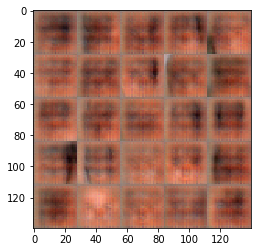

Epoch 2/2... Discriminator Loss: 1.0260... Generator Loss: 0.9027
Epoch 2/2... Discriminator Loss: 1.0878... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 1.2676... Generator Loss: 1.2778
Epoch 2/2... Discriminator Loss: 1.4772... Generator Loss: 0.3722
Epoch 2/2... Discriminator Loss: 1.5307... Generator Loss: 0.3243
Epoch 2/2... Discriminator Loss: 1.0533... Generator Loss: 0.7279
Epoch 2/2... Discriminator Loss: 1.1540... Generator Loss: 0.6054
Epoch 2/2... Discriminator Loss: 1.0359... Generator Loss: 1.0658
Epoch 2/2... Discriminator Loss: 1.0938... Generator Loss: 0.9168
Epoch 2/2... Discriminator Loss: 1.2150... Generator Loss: 0.5716


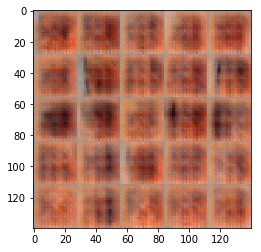

Epoch 2/2... Discriminator Loss: 1.1011... Generator Loss: 1.1096
Epoch 2/2... Discriminator Loss: 1.2226... Generator Loss: 0.6093
Epoch 2/2... Discriminator Loss: 1.1982... Generator Loss: 0.5797
Epoch 2/2... Discriminator Loss: 1.0680... Generator Loss: 0.9939
Epoch 2/2... Discriminator Loss: 1.0730... Generator Loss: 0.7712
Epoch 2/2... Discriminator Loss: 1.1842... Generator Loss: 0.5754
Epoch 2/2... Discriminator Loss: 1.2864... Generator Loss: 0.5989
Epoch 2/2... Discriminator Loss: 1.2999... Generator Loss: 1.3370
Epoch 2/2... Discriminator Loss: 0.9638... Generator Loss: 0.8735
Epoch 2/2... Discriminator Loss: 1.4251... Generator Loss: 0.4587


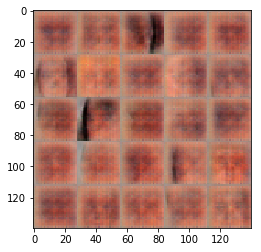

Epoch 2/2... Discriminator Loss: 1.1608... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 1.3807... Generator Loss: 0.4444
Epoch 2/2... Discriminator Loss: 1.0205... Generator Loss: 0.8020
Epoch 2/2... Discriminator Loss: 1.1340... Generator Loss: 1.3722
Epoch 2/2... Discriminator Loss: 1.0998... Generator Loss: 0.6853
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 1.1076
Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 0.4747
Epoch 2/2... Discriminator Loss: 1.0649... Generator Loss: 0.9019
Epoch 2/2... Discriminator Loss: 1.0176... Generator Loss: 0.8473
Epoch 2/2... Discriminator Loss: 1.0782... Generator Loss: 0.7042


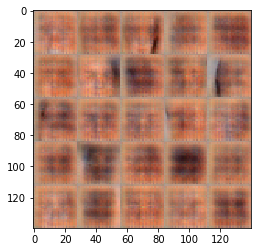

Epoch 2/2... Discriminator Loss: 1.3993... Generator Loss: 0.4603
Epoch 2/2... Discriminator Loss: 1.0044... Generator Loss: 1.0593
Epoch 2/2... Discriminator Loss: 0.9844... Generator Loss: 0.9769
Epoch 2/2... Discriminator Loss: 1.1923... Generator Loss: 0.6830
Epoch 2/2... Discriminator Loss: 0.9110... Generator Loss: 1.0486
Epoch 2/2... Discriminator Loss: 1.0991... Generator Loss: 0.7016
Epoch 2/2... Discriminator Loss: 1.2114... Generator Loss: 0.8142
Epoch 2/2... Discriminator Loss: 1.3240... Generator Loss: 0.5015
Epoch 2/2... Discriminator Loss: 1.0355... Generator Loss: 0.8017
Epoch 2/2... Discriminator Loss: 1.0993... Generator Loss: 0.8273


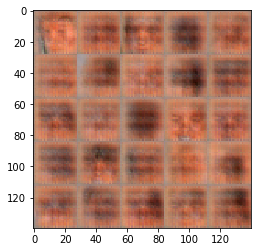

Epoch 2/2... Discriminator Loss: 1.2989... Generator Loss: 0.5246
Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 0.4862
Epoch 2/2... Discriminator Loss: 1.0659... Generator Loss: 0.7111
Epoch 2/2... Discriminator Loss: 1.0862... Generator Loss: 0.8173
Epoch 2/2... Discriminator Loss: 1.1466... Generator Loss: 1.5220
Epoch 2/2... Discriminator Loss: 1.0830... Generator Loss: 0.6750
Epoch 2/2... Discriminator Loss: 1.1180... Generator Loss: 0.7660
Epoch 2/2... Discriminator Loss: 1.0673... Generator Loss: 1.0385
Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 0.8376
Epoch 2/2... Discriminator Loss: 1.2351... Generator Loss: 0.7930


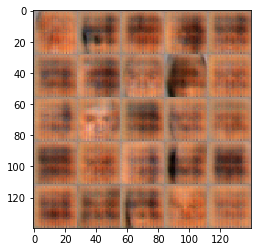

Epoch 2/2... Discriminator Loss: 1.1085... Generator Loss: 1.0150
Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 0.5634
Epoch 2/2... Discriminator Loss: 1.1463... Generator Loss: 1.1128
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 1.3527
Epoch 2/2... Discriminator Loss: 1.1112... Generator Loss: 0.8511
Epoch 2/2... Discriminator Loss: 1.2198... Generator Loss: 0.6156
Epoch 2/2... Discriminator Loss: 1.1430... Generator Loss: 0.9804
Epoch 2/2... Discriminator Loss: 1.3698... Generator Loss: 1.0285
Epoch 2/2... Discriminator Loss: 1.1114... Generator Loss: 1.5969
Epoch 2/2... Discriminator Loss: 1.0967... Generator Loss: 0.8307


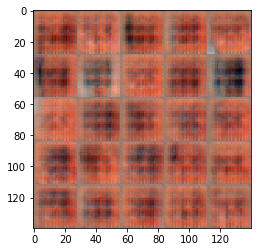

Epoch 2/2... Discriminator Loss: 1.0952... Generator Loss: 0.7614
Epoch 2/2... Discriminator Loss: 1.0313... Generator Loss: 0.9925
Epoch 2/2... Discriminator Loss: 1.1692... Generator Loss: 0.8357
Epoch 2/2... Discriminator Loss: 1.1294... Generator Loss: 0.7539
Epoch 2/2... Discriminator Loss: 1.2299... Generator Loss: 0.5771
Epoch 2/2... Discriminator Loss: 1.1382... Generator Loss: 1.3135
Epoch 2/2... Discriminator Loss: 1.1187... Generator Loss: 0.8124
Epoch 2/2... Discriminator Loss: 1.3205... Generator Loss: 0.4934
Epoch 2/2... Discriminator Loss: 1.1457... Generator Loss: 0.7548
Epoch 2/2... Discriminator Loss: 1.1223... Generator Loss: 0.9288


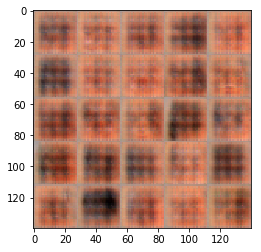

Epoch 2/2... Discriminator Loss: 1.2126... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 1.1514... Generator Loss: 0.5601
Epoch 2/2... Discriminator Loss: 1.1040... Generator Loss: 0.9854
Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 0.7382
Epoch 2/2... Discriminator Loss: 1.4125... Generator Loss: 0.4396
Epoch 2/2... Discriminator Loss: 1.1038... Generator Loss: 0.7404
Epoch 2/2... Discriminator Loss: 1.2249... Generator Loss: 0.6095
Epoch 2/2... Discriminator Loss: 1.1778... Generator Loss: 0.7033
Epoch 2/2... Discriminator Loss: 1.0574... Generator Loss: 0.7136
Epoch 2/2... Discriminator Loss: 1.1147... Generator Loss: 0.7576


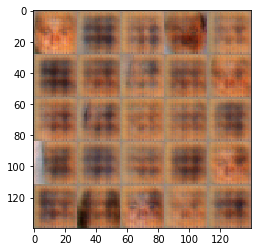

Epoch 2/2... Discriminator Loss: 1.0424... Generator Loss: 0.7111
Epoch 2/2... Discriminator Loss: 1.0529... Generator Loss: 0.9213
Epoch 2/2... Discriminator Loss: 1.0706... Generator Loss: 1.0701
Epoch 2/2... Discriminator Loss: 1.1243... Generator Loss: 1.0710
Epoch 2/2... Discriminator Loss: 1.1175... Generator Loss: 1.1038
Epoch 2/2... Discriminator Loss: 1.0826... Generator Loss: 0.9827
Epoch 2/2... Discriminator Loss: 0.9855... Generator Loss: 0.8411
Epoch 2/2... Discriminator Loss: 1.3679... Generator Loss: 0.4428
Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 0.8266
Epoch 2/2... Discriminator Loss: 1.1175... Generator Loss: 1.0146


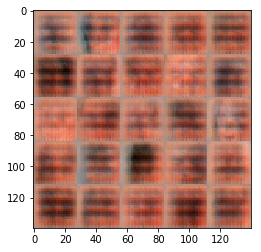

Epoch 2/2... Discriminator Loss: 1.0919... Generator Loss: 0.8331
Epoch 2/2... Discriminator Loss: 1.2499... Generator Loss: 1.5325
Epoch 2/2... Discriminator Loss: 1.0118... Generator Loss: 0.6995
Epoch 2/2... Discriminator Loss: 1.0728... Generator Loss: 0.7357
Epoch 2/2... Discriminator Loss: 1.1454... Generator Loss: 0.7297
Epoch 2/2... Discriminator Loss: 1.0220... Generator Loss: 1.0046
Epoch 2/2... Discriminator Loss: 1.2744... Generator Loss: 0.5370
Epoch 2/2... Discriminator Loss: 1.0434... Generator Loss: 0.8415
Epoch 2/2... Discriminator Loss: 1.0872... Generator Loss: 1.2425
Epoch 2/2... Discriminator Loss: 1.1404... Generator Loss: 0.9839


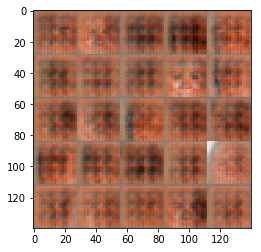

Epoch 2/2... Discriminator Loss: 1.1960... Generator Loss: 0.6009
Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 0.8280
Epoch 2/2... Discriminator Loss: 1.1792... Generator Loss: 0.8535
Epoch 2/2... Discriminator Loss: 1.5475... Generator Loss: 2.0495
Epoch 2/2... Discriminator Loss: 1.1663... Generator Loss: 0.9983
Epoch 2/2... Discriminator Loss: 1.0017... Generator Loss: 0.9016
Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 0.6545
Epoch 2/2... Discriminator Loss: 1.1112... Generator Loss: 0.7347
Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 0.9438
Epoch 2/2... Discriminator Loss: 1.0363... Generator Loss: 1.1300


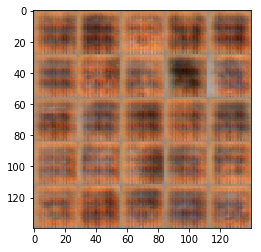

Epoch 2/2... Discriminator Loss: 1.0798... Generator Loss: 0.7178
Epoch 2/2... Discriminator Loss: 1.3235... Generator Loss: 0.4217
Epoch 2/2... Discriminator Loss: 1.1413... Generator Loss: 0.8250
Epoch 2/2... Discriminator Loss: 1.1906... Generator Loss: 0.5877
Epoch 2/2... Discriminator Loss: 1.1252... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 1.1292... Generator Loss: 0.5827
Epoch 2/2... Discriminator Loss: 1.0545... Generator Loss: 0.8618
Epoch 2/2... Discriminator Loss: 1.1836... Generator Loss: 0.8103
Epoch 2/2... Discriminator Loss: 1.1720... Generator Loss: 0.6775
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 0.8858


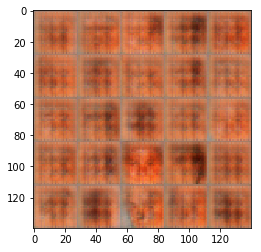

Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 1.1745
Epoch 2/2... Discriminator Loss: 1.0083... Generator Loss: 0.8849
Epoch 2/2... Discriminator Loss: 1.0475... Generator Loss: 0.8110
Epoch 2/2... Discriminator Loss: 0.9106... Generator Loss: 0.9323
Epoch 2/2... Discriminator Loss: 0.9759... Generator Loss: 1.1459
Epoch 2/2... Discriminator Loss: 0.9580... Generator Loss: 1.0196
Epoch 2/2... Discriminator Loss: 1.0871... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 1.1658... Generator Loss: 0.5929
Epoch 2/2... Discriminator Loss: 1.1159... Generator Loss: 0.8693
Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 0.7020


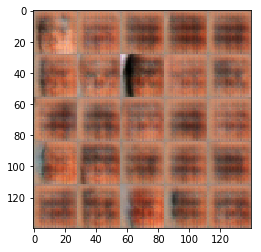

Epoch 2/2... Discriminator Loss: 1.2682... Generator Loss: 0.5557
Epoch 2/2... Discriminator Loss: 1.1246... Generator Loss: 0.8635
Epoch 2/2... Discriminator Loss: 1.3315... Generator Loss: 0.6160
Epoch 2/2... Discriminator Loss: 1.2241... Generator Loss: 0.7417
Epoch 2/2... Discriminator Loss: 1.2326... Generator Loss: 0.6110
Epoch 2/2... Discriminator Loss: 1.2418... Generator Loss: 0.5698
Epoch 2/2... Discriminator Loss: 1.1065... Generator Loss: 1.0257
Epoch 2/2... Discriminator Loss: 1.0469... Generator Loss: 0.8782
Epoch 2/2... Discriminator Loss: 1.0131... Generator Loss: 0.7804
Epoch 2/2... Discriminator Loss: 1.1141... Generator Loss: 0.7817


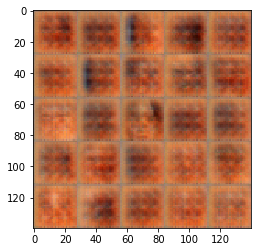

Epoch 2/2... Discriminator Loss: 1.1315... Generator Loss: 0.7585
Epoch 2/2... Discriminator Loss: 1.0763... Generator Loss: 0.7591
Epoch 2/2... Discriminator Loss: 1.1822... Generator Loss: 0.8876
Epoch 2/2... Discriminator Loss: 1.1097... Generator Loss: 0.9558
Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 0.7326
Epoch 2/2... Discriminator Loss: 0.9721... Generator Loss: 1.0629
Epoch 2/2... Discriminator Loss: 1.2425... Generator Loss: 0.5030
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 0.5661
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 1.1293... Generator Loss: 0.7745


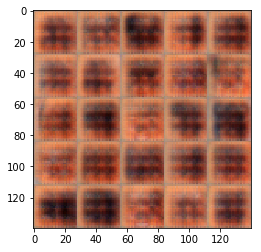

Epoch 2/2... Discriminator Loss: 1.2367... Generator Loss: 0.6268
Epoch 2/2... Discriminator Loss: 1.2087... Generator Loss: 0.5781
Epoch 2/2... Discriminator Loss: 0.9764... Generator Loss: 1.0738
Epoch 2/2... Discriminator Loss: 1.2607... Generator Loss: 0.5659
Epoch 2/2... Discriminator Loss: 1.2527... Generator Loss: 0.6302
Epoch 2/2... Discriminator Loss: 1.0827... Generator Loss: 0.8486
Epoch 2/2... Discriminator Loss: 1.1656... Generator Loss: 1.2767
Epoch 2/2... Discriminator Loss: 1.1266... Generator Loss: 0.7463
Epoch 2/2... Discriminator Loss: 1.0802... Generator Loss: 0.8325
Epoch 2/2... Discriminator Loss: 1.2196... Generator Loss: 0.7130


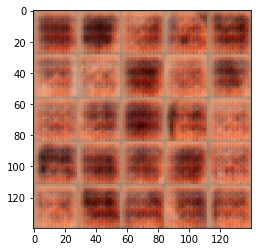

Epoch 2/2... Discriminator Loss: 1.2880... Generator Loss: 0.6159
Epoch 2/2... Discriminator Loss: 1.0914... Generator Loss: 0.9013
Epoch 2/2... Discriminator Loss: 1.1058... Generator Loss: 1.1051
Epoch 2/2... Discriminator Loss: 1.0378... Generator Loss: 0.8373
Epoch 2/2... Discriminator Loss: 0.9876... Generator Loss: 0.9038
Epoch 2/2... Discriminator Loss: 1.0735... Generator Loss: 1.2107
Epoch 2/2... Discriminator Loss: 1.1509... Generator Loss: 0.7765
Epoch 2/2... Discriminator Loss: 1.2354... Generator Loss: 0.7003
Epoch 2/2... Discriminator Loss: 1.2357... Generator Loss: 0.5731
Epoch 2/2... Discriminator Loss: 1.1321... Generator Loss: 0.9649


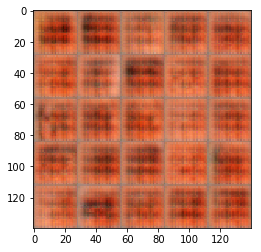

Epoch 2/2... Discriminator Loss: 1.1008... Generator Loss: 0.8515
Epoch 2/2... Discriminator Loss: 1.0663... Generator Loss: 0.8828
Epoch 2/2... Discriminator Loss: 1.3381... Generator Loss: 0.5603
Epoch 2/2... Discriminator Loss: 1.2254... Generator Loss: 0.9267
Epoch 2/2... Discriminator Loss: 0.9993... Generator Loss: 0.8779
Epoch 2/2... Discriminator Loss: 1.0762... Generator Loss: 0.8059
Epoch 2/2... Discriminator Loss: 0.9993... Generator Loss: 0.8755
Epoch 2/2... Discriminator Loss: 1.2416... Generator Loss: 0.5680
Epoch 2/2... Discriminator Loss: 1.3229... Generator Loss: 0.7315
Epoch 2/2... Discriminator Loss: 1.0540... Generator Loss: 1.0361


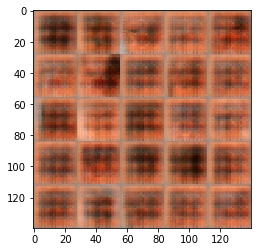

Epoch 2/2... Discriminator Loss: 1.1173... Generator Loss: 0.8524
Epoch 2/2... Discriminator Loss: 0.9477... Generator Loss: 0.8404
Epoch 2/2... Discriminator Loss: 1.2057... Generator Loss: 0.8704
Epoch 2/2... Discriminator Loss: 1.2802... Generator Loss: 0.8018
Epoch 2/2... Discriminator Loss: 1.3127... Generator Loss: 0.4728
Epoch 2/2... Discriminator Loss: 1.2891... Generator Loss: 1.0404
Epoch 2/2... Discriminator Loss: 1.2327... Generator Loss: 0.5546
Epoch 2/2... Discriminator Loss: 1.3609... Generator Loss: 0.4542
Epoch 2/2... Discriminator Loss: 0.9861... Generator Loss: 1.0006
Epoch 2/2... Discriminator Loss: 0.9775... Generator Loss: 1.0367


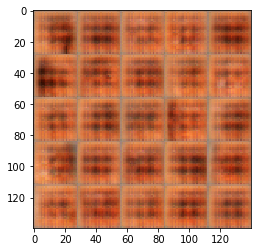

Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 0.9643
Epoch 2/2... Discriminator Loss: 1.1070... Generator Loss: 0.7158
Epoch 2/2... Discriminator Loss: 1.2862... Generator Loss: 1.0175
Epoch 2/2... Discriminator Loss: 1.0734... Generator Loss: 0.7353
Epoch 2/2... Discriminator Loss: 1.2972... Generator Loss: 0.6518
Epoch 2/2... Discriminator Loss: 1.5518... Generator Loss: 1.9070
Epoch 2/2... Discriminator Loss: 1.2864... Generator Loss: 0.7606
Epoch 2/2... Discriminator Loss: 1.1390... Generator Loss: 1.1296
Epoch 2/2... Discriminator Loss: 1.1453... Generator Loss: 0.7523
Epoch 2/2... Discriminator Loss: 1.0962... Generator Loss: 0.9071


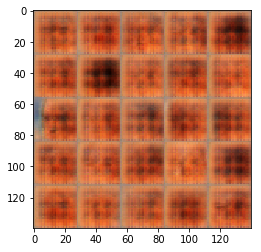

Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 0.7687
Epoch 2/2... Discriminator Loss: 1.0008... Generator Loss: 0.8565
Epoch 2/2... Discriminator Loss: 1.4021... Generator Loss: 0.4541
Epoch 2/2... Discriminator Loss: 1.4981... Generator Loss: 0.3646
Epoch 2/2... Discriminator Loss: 1.1202... Generator Loss: 0.9622
Epoch 2/2... Discriminator Loss: 1.0303... Generator Loss: 0.9773
Epoch 2/2... Discriminator Loss: 1.2343... Generator Loss: 0.9694
Epoch 2/2... Discriminator Loss: 1.0079... Generator Loss: 0.8050
Epoch 2/2... Discriminator Loss: 1.1060... Generator Loss: 0.9787
Epoch 2/2... Discriminator Loss: 1.1112... Generator Loss: 0.8901


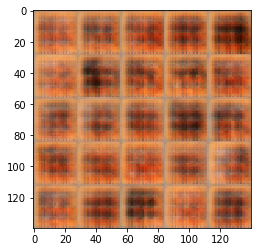

Epoch 2/2... Discriminator Loss: 1.1323... Generator Loss: 0.6803
Epoch 2/2... Discriminator Loss: 1.2696... Generator Loss: 0.7722
Epoch 2/2... Discriminator Loss: 1.1680... Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 1.1447... Generator Loss: 1.0836


In [19]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.